<a href="https://colab.research.google.com/github/hoohahaBIGHEAD/AI/blob/main/%EB%94%B0%EB%A6%89%EC%9D%B4_%EB%8C%80%EC%97%AC%EC%88%98_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 라이브러리 및 데이터
##Library & Data

In [ ]:
!pip install pycaret
!pip install optuna


     |████████████████████████████████| 301 kB 12.5 MB/s 
     |████████████████████████████████| 6.8 MB 28.8 MB/s 
     |████████████████████████████████| 15.6 MB 76.4 MB/s 
     |████████████████████████████████| 167 kB 71.9 MB/s 
     |████████████████████████████████| 114 kB 81.1 MB/s 
     |████████████████████████████████| 56 kB 6.2 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 1.7 MB 63.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 61.4 MB/s 
     |████████████████████████████████| 261 kB 76.3 MB/s 
     |████████████████████████████████| 2.0 MB 44.6 MB/s 
     |████████████████████████████████| 102 kB 14.1 MB/s 
     |████████████████████████████████| 636 kB 63.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |██████████████████

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

##데이터 로딩 및 확인

In [ ]:
bike_data = pd.read_csv('/content/drive/MyDrive/tmp/따릉이/train.csv')
bike_data.drop(['id'], axis = 1, inplace=True)
test = pd.read_csv('/content/drive/MyDrive/tmp/따릉이/test.csv')
test.drop(['id'], axis = 1, inplace=True)
submission = pd.read_csv('/content/drive/MyDrive/tmp/따릉이/submission.csv')

보간용 데이터 합치기

In [ ]:
bike_data['isTrain'] = True
test['isTrain'] = False

total = pd.concat([bike_data, test])
total.shape

(2174, 11)

결측치 처리

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

it_train = total.copy()
it_train = IterativeImputer(random_state=1).fit_transform(it_train)

itImp = pd.DataFrame(it_train)
itImp.columns = total.columns

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [ ]:
itImp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    2174 non-null   float64
 1   hour_bef_temperature    2174 non-null   float64
 2   hour_bef_precipitation  2174 non-null   float64
 3   hour_bef_windspeed      2174 non-null   float64
 4   hour_bef_humidity       2174 non-null   float64
 5   hour_bef_visibility     2174 non-null   float64
 6   hour_bef_ozone          2174 non-null   float64
 7   hour_bef_pm10           2174 non-null   float64
 8   hour_bef_pm2.5          2174 non-null   float64
 9   count                   2174 non-null   float64
 10  isTrain                 2174 non-null   float64
dtypes: float64(11)
memory usage: 187.0 KB


이상치 처리

In [ ]:
itImp_mid = itImp.copy()

# 4분위를 적용할 컬럼명
col_name = total.columns.drop(['hour_bef_precipitation'])
for iIt in col_name:
  Q1=itImp_mid[iIt].quantile(0.25)
  Q3=itImp_mid[iIt].quantile(0.75)
  IQR = Q3-Q1
  for i in range(2174):
    if itImp_mid[iIt][i] < (Q1 - 1.5*IQR):
      itImp_mid[iIt][i] = (Q1 - 1.5*IQR)
    elif itImp_mid[iIt][i] > (Q3 + 1.5*IQR):
      itImp_mid[iIt][i] = (Q3 + 1.5*IQR)
  #train_delout = itImp_mid[(itImp_mid[iIt]<(Q1 - 1.5*IQR)) | (itImp_mid[iIt] > (Q3 + 1.5*IQR))]
  #itImp_mid = itImp_mid.drop(train_delout.index, axis = 0)

itImp_mid.shape

(2174, 11)

더미변수 추가


In [ ]:
def busyHourGen(data, col):
  lst = data[col]
  lst_ = []
  for i in lst:
    if (6 < i < 10) or (16 < i < 20):
      lst_.append(1)
    else:
      lst_.append(0)
  data['busy_hour'] = lst_
  return data

an_bef = busyHourGen(itImp_mid, 'hour') # an_bef = busy_hour 추가된 데이터셋

테스트셋 트레인셋 분리

In [ ]:
tmp = an_bef[(an_bef['isTrain'] == False)]
an = an_bef.drop(tmp.index, axis=0).copy()
an.drop(['isTrain'], axis=1, inplace=True)

tmp = an_bef[(an_bef['isTrain'] == True)]
test = an_bef.drop(tmp.index, axis=0).copy()
test.drop(['isTrain', 'count'], axis=1, inplace=True)

print(an.shape)
print(test.shape)
test.info()

(1459, 11)
(715, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 1459 to 2173
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    715 non-null    float64
 1   hour_bef_temperature    715 non-null    float64
 2   hour_bef_precipitation  715 non-null    float64
 3   hour_bef_windspeed      715 non-null    float64
 4   hour_bef_humidity       715 non-null    float64
 5   hour_bef_visibility     715 non-null    float64
 6   hour_bef_ozone          715 non-null    float64
 7   hour_bef_pm10           715 non-null    float64
 8   hour_bef_pm2.5          715 non-null    float64
 9   busy_hour               715 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 61.4 KB


In [ ]:
# Filter rows with missing price values
# X = an.drop(['count'], axis=1)
X = an[an.columns.difference(['count', 'hour_bef_visibility'])]
print(X.info())
# X = np.column_stack((X['hour']**5, X['hour_bef_temperature']**4, X))
y = an['count']
#train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, test_size=0.33)
#X[:5]
test = test[test.columns.difference(['hour_bef_visibility'])]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   busy_hour               1459 non-null   int64  
 1   hour                    1459 non-null   float64
 2   hour_bef_humidity       1459 non-null   float64
 3   hour_bef_ozone          1459 non-null   float64
 4   hour_bef_pm10           1459 non-null   float64
 5   hour_bef_pm2.5          1459 non-null   float64
 6   hour_bef_precipitation  1459 non-null   float64
 7   hour_bef_temperature    1459 non-null   float64
 8   hour_bef_windspeed      1459 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 114.0 KB
None


In [ ]:
def objective_extratree(trial):
  params_et = {
      "n_estimators": trial.suggest_int("n_estimators", 950, 970, step=1),
      # "n_estimators": trial.suggest_int("n_estimators", 635, 655, step=1),
      "max_depth": trial.suggest_int("max_depth", 20, 20),
      "min_samples_split": trial.suggest_int("min_samples_split",2, 2),
      "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1,1),
      "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", 4, 5, 6]),
      # "max_features": trial.suggest_categorical("max_features", ["auto"]),
      "warm_start": trial.suggest_categorical("warm_start", [True, False]),
      # "warm_start": trial.suggest_categorical("warm_start", [True]),
      "random_state": 1
  }

  X = an[an.columns.difference(['count', 'hour_bef_visibility'])]
  y = an['count']
  train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, test_size=0.33)

  model = ExtraTreesRegressor(**params_et)
  model.fit(train_X, train_y)

  pred = model.predict(val_X)
  rmse = np.sqrt(mean_squared_error(val_y, pred))

  return rmse

In [ ]:
sampler = TPESampler(seed=1)
study = optuna.create_study(
    study_name="et_optimizer",
    direction="minimize", 
    sampler=sampler,
    )

[I 2022-01-21 22:13:16,808] A new study created in memory with name: et_optimizer


In [ ]:
study.optimize(objective_extratree, n_trials=30)

[I 2022-01-21 22:13:19,679] Trial 0 finished with value: 36.57954875524887 and parameters: {'n_estimators': 958, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'warm_start': False}. Best is trial 0 with value: 36.57954875524887.
[I 2022-01-21 22:13:21,510] Trial 1 finished with value: 35.649483292567105 and parameters: {'n_estimators': 961, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 4, 'warm_start': False}. Best is trial 1 with value: 35.649483292567105.
[I 2022-01-21 22:13:23,183] Trial 2 finished with value: 35.97636428666921 and parameters: {'n_estimators': 952, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'warm_start': True}. Best is trial 1 with value: 35.649483292567105.
[I 2022-01-21 22:13:25,107] Trial 3 finished with value: 35.80013163252145 and parameters: {'n_estimators': 950, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 

In [ ]:
#test.shape
#test.info()

In [ ]:
#독립변수, 종속변수 설정
X = an[an.columns.difference(['id', 'count', 'hour_bef_visibility'])]
colls = X.columns.tolist()
# X = np.column_stack((X['hour']**5, X['hour_bef_temperature']**4, X))
y = an['count']

#테스트셋 전처리(결측치, 더미 변수 추가)
it_test = test[test.columns.difference(['id', 'hour_bef_visibility'])].copy()
it_test = busyHourGen(it_test, 'hour')
it_test = it_test[colls]
# X_test = np.column_stack((it_test['hour']**5, it_test['hour_bef_temperature']**4, it_test))
#X_test = IterativeImputer(random_state=1).fit_transform(X_test)
X_test = test

print(it_test.info())
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 1459 to 2173
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   busy_hour               715 non-null    int64  
 1   hour                    715 non-null    float64
 2   hour_bef_humidity       715 non-null    float64
 3   hour_bef_ozone          715 non-null    float64
 4   hour_bef_pm10           715 non-null    float64
 5   hour_bef_pm2.5          715 non-null    float64
 6   hour_bef_precipitation  715 non-null    float64
 7   hour_bef_temperature    715 non-null    float64
 8   hour_bef_windspeed      715 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 55.9 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 1459 to 2173
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   busy_hour               715 non-nu

In [ ]:
# ExtraTreesRegressor
best_reg = ExtraTreesRegressor(
    n_estimators=640, 
    max_depth=18, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features=5, 
    warm_start=False, 
    random_state=1)
best_reg.fit(X, y)
predicts = best_reg.predict(X_test)

submission['count'] = predicts
submission.to_csv('final.csv', index=False)

submission['count'] = predicts.round(0)
submission.to_csv('final_rounded.csv', index=False)

변수 중요도 확인

38.63594946842958


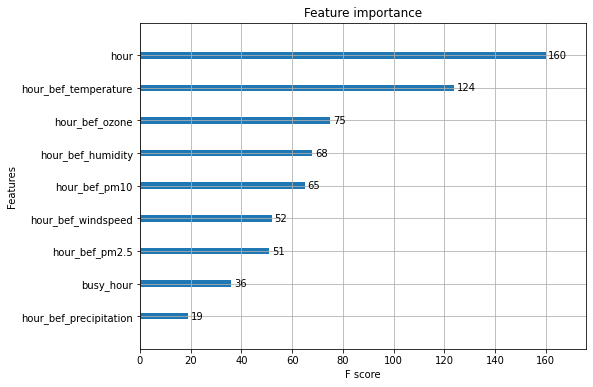

In [ ]:
from xgboost import XGBRegressor
from xgboost import plot_importance

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, test_size=0.33)

xgbr_all = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=1)
xgbr_all.fit(train_X, train_y)
pred = xgbr_all.predict(val_X)

rmse = np.sqrt(mean_squared_error(val_y, pred))
print(rmse)

fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(xgbr_all, ax=ax)

In [ ]:
df_train = pd.DataFrame(itImp_mid, columns=col_name)
from pycaret.regression import *
reg = setup(df_train, target = 'count', train_size=0.8)

,Description,Value
0,session_id,902
1,Target,count
2,Original Data,"(2174, 10)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1739, 9)"


In [ ]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,19.0174,982.3155,31.2735,0.8347,0.4599,0.7351,0.552
lightgbm,Light Gradient Boosting Machine,21.4337,1079.8011,32.7477,0.8183,0.4893,0.7692,0.089
rf,Random Forest Regressor,20.6881,1140.0958,33.6522,0.8087,0.4688,0.7644,0.779
gbr,Gradient Boosting Regressor,23.1085,1236.2059,35.0745,0.7916,0.5127,0.8466,0.180
lar,Least Angle Regression,28.1174,1892.8642,43.4228,0.6814,0.6746,1.0514,0.013
lr,Linear Regression,28.1174,1892.8661,43.4229,0.6814,0.6746,1.0514,0.237
ridge,Ridge Regression,27.9533,1895.0634,43.4499,0.6811,0.6660,1.0466,0.010
br,Bayesian Ridge,28.0156,1896.2773,43.4637,0.6810,0.6663,1.0457,0.011
lasso,Lasso Regression,28.1059,1896.3888,43.4646,0.6810,0.6669,1.0463,0.013
en,Elastic Net,28.3042,1898.9517,43.4945,0.6806,0.6724,1.0445,0.011


bike_data[ hour ]의 왜도:  0.003659038646423124
bike_data[ hour_bef_temperature ]의 왜도:  0.17522408110232682
bike_data[ hour_bef_precipitation ]의 왜도:  5.363369262328469
bike_data[ hour_bef_windspeed ]의 왜도:  0.559761388501819
bike_data[ hour_bef_humidity ]의 왜도:  0.14944445493832664
bike_data[ hour_bef_visibility ]의 왜도:  -0.4842749631294303
bike_data[ hour_bef_ozone ]의 왜도:  0.39730312582811467
bike_data[ hour_bef_pm10 ]의 왜도:  2.3854639567027447
bike_data[ hour_bef_pm2.5 ]의 왜도:  1.3566878820269048
bike_data[ count ]의 왜도:  0.9125336769560027
bike_data[ isTrain ]의 왜도:  0


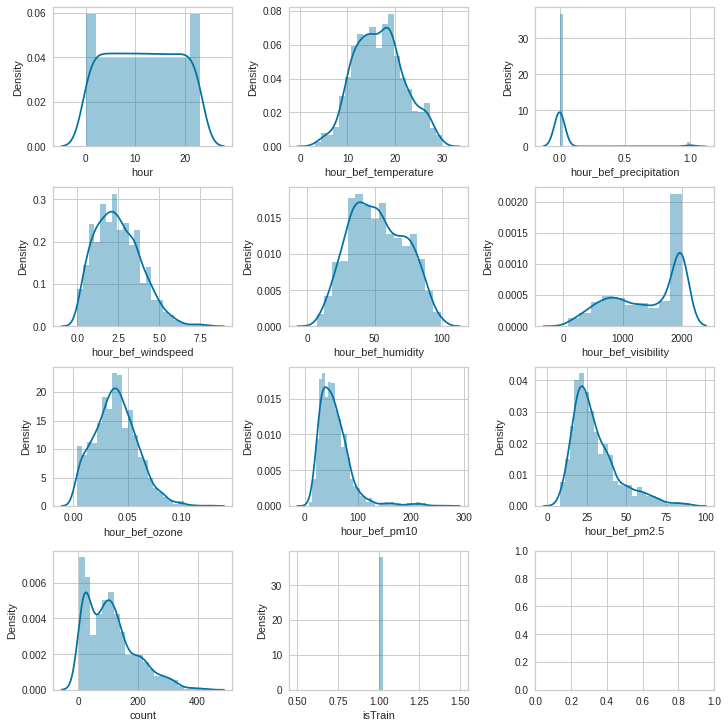

In [ ]:


#bike_data['hour_bef_ozone'] = np.log(bike_data['hour_bef_ozone']+1)
#bike_data['hour_bef_pm10'] = np.log(bike_data['hour_bef_pm10']+1)
#bike_data['hour_bef_pm2.5'] = np.log(bike_data['hour_bef_pm2.5']+1)
 #= bike_data[['hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']].apply(lambda x: np.log(x+1))

f, axes = plt.subplots(4, 3, figsize = (10, 10), constrained_layout=True)
for i, feature in enumerate(bike_data.columns):
  sns.distplot(bike_data[feature], ax = axes[i//3, i%3])
  print("bike_data[", feature, "]의 왜도: ", bike_data[feature].skew())

plt.show()

# fb = fb[['hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']].apply(lambda x: np.log(x+1))

##val data 분리

In [ ]:
# from sklearn.model_selection import train_test_split

# # Filter rows with missing price values
# filtered_bike_data = bike_data.dropna(axis=0)
# X = filtered_bike_data.drop(['count'], axis=1)
# y = filtered_bike_data['count']

# train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle = True, random_state=1, test_size=0.2)

#2. 탐색적 자료분석(EDA)
##기존 데이터 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    1459 non-null   int64  
 1   hour_bef_temperature    1457 non-null   float64
 2   hour_bef_precipitation  1457 non-null   float64
 3   hour_bef_windspeed      1450 non-null   float64
 4   hour_bef_humidity       1457 non-null   float64
 5   hour_bef_visibility     1457 non-null   float64
 6   hour_bef_ozone          1383 non-null   float64
 7   hour_bef_pm10           1369 non-null   float64
 8   hour_bef_pm2.5          1342 non-null   float64
 9   count                   1459 non-null   float64
 10  isTrain                 1459 non-null   bool   
dtypes: bool(1), float64(9), int64(1)
memory usage: 115.5 KB


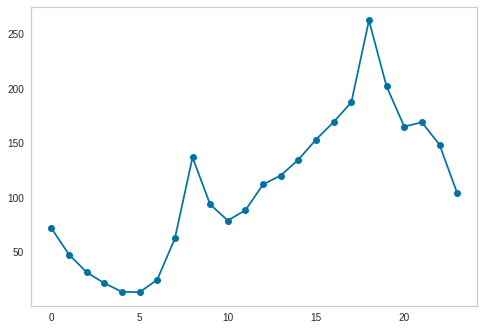

In [ ]:
import matplotlib.pyplot as plt

bike_data.isna().sum()
bike_data.info()
#bike_data.groupby('hour').mean()['hour_bef_windspeed'].plot()
#bike_data[bike_data['hour_bef_temperature'].isna()]
# hour 기준으로 평균을 내고 카운트를 출력
#bike_data.groupby('hour').mean()['count'].plot()
plt.plot(bike_data.groupby('hour').mean()['count'], 'o-')
plt.grid()

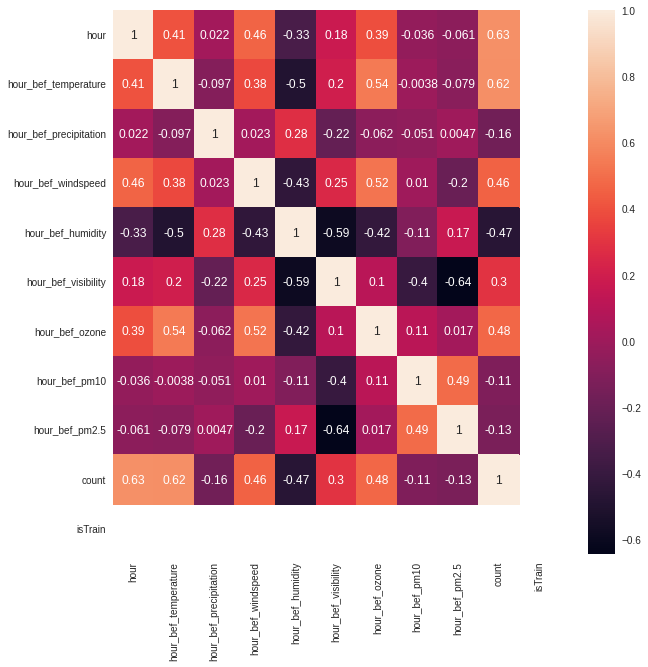

In [ ]:
#print(bike_data.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(bike_data.corr(), annot=True)

##모델 정의 및 학습

In [ ]:
# added_test = busyHourGen(itImp_test, 'hour') # added_test = busy_hour 추가된 데이터셋
# added_test.describe()

In [ ]:
# model = RandomForestRegressor()
# #model.fit(train_X, train_y)
# model.fit(X, y)
# test.fillna(0,inplace = True)


# pred = model.predict(test)

# #submission['count'] = pred
# submission.to_csv('베이스라인_테스트만0.csv',index = False)
# # plt.scatter(val_y, pred)
# # plt.show()
# # #print(pred)
# # print(mean_squared_error(val_y, pred)**0.5)

##DNN을 위한 데이터 정규화

In [ ]:
# dnn을 min max 데이터 정규화

min_X = train_X.min()
max_X = train_X.max()
def normalize_X(X):
  return (X - min_X) / (max_X - min_X)

min_y = train_y.min()
max_y = train_y.max()
def normalize_y(y):
  return (y - min_y) / (max_y - min_y)

def denormalize_y(y):
  return (max_y - min_y) * y + min_y

norm_train_X = normalize_X(train_X)
norm_val_X = normalize_X(val_X)
norm_train_y = normalize_y(train_y)
norm_val_y = normalize_y(val_y)

print(norm_train_X[:5])
print(norm_val_X[:5])
print(norm_train_y[:5])
print(norm_val_y[:5])

     busy_hour  hour  ...  hour_bef_temperature  hour_bef_windspeed
766          0  11.0  ...                  14.5                 2.2
274          0   6.0  ...                  13.4                 1.9
205          0  20.0  ...                  19.7                 4.3
534          0  21.0  ...                  13.5                 3.6
286          1   8.0  ...                  14.7                 1.6

[5 rows x 9 columns]
      busy_hour  hour  ...  hour_bef_temperature  hour_bef_windspeed
1108          0  13.0  ...                  20.1                 5.0
111           0  10.0  ...                  11.7                 1.0
1273          0   1.0  ...                  10.6                 0.2
1147          0  22.0  ...                  21.9                 3.1
368           0   0.0  ...                  15.4                 2.4

[5 rows x 9 columns]
766     71.0
274     36.0
205    244.0
534    141.0
286     56.0
Name: count, dtype: float64
1108    134.0
111      65.0
1273     67.0

In [ ]:
# model = RandomForestRegressor()
# model.fit(norm_train_X, norm_train_y)
# pred = model.predict(norm_val_X)
# denorm_pred = denormalize_y(pred)

# plt.scatter(val_y, pred)
# plt.show()
# #print(pred)
# print(mean_squared_error(val_y, denorm_pred)**0.5)

In [79]:
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from keras import models
from keras import layers


def build_model(): # 동일한 모델을 여러 번 생성할 것
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model

In [80]:
# model = keras.Sequential()
# model.add(Dense(64, activation='relu', input_shape=(9,)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1))

# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# model.summary()

In [81]:
k = 4
# train_data = train_X
# train_targets = train_y
train_data = norm_train_X
train_targets = norm_train_y
num_val_samples = len(train_data) // k

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  #검증 데이터 준비: k번째 분할    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

model = build_model()  # 케라스 모델 구성(컴파일 포함)
history = model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
                    validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=1, verbose=1)


처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                640       
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
733/733 [==============================] - 2s 2ms/step - loss: 0.0231 - mae: 0.1132 - val_loss: 0.0149 - val_mae: 0.0924
Epoch 2/500
733/733 [==============================] - 2s 2ms/step - loss: 0.0185 - mae: 0.1016 - val_loss: 0.0129 - val_mae: 0.0842
Ep

 에포크의 검증 점수를 로그에 저장하겠습니다.

In [82]:
mae_history = history.history['val_mae']
all_mae_histories.append(mae_history)

그다음 모든 폴드에 대해 에포크의 MAE 점수 평균을 계산합니다.

In [83]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

그래프로 나타내기

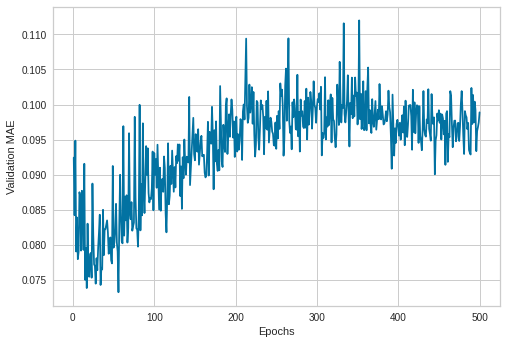

In [84]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#####곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외시킵니다.
#####부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균exponential moving average으로 대체합니다.43

지수 이동 평균은 시계열 데이터를 부드럽게 만드는 기법 중 하나입니다. 코드 3-31의 6번째 줄에서 이전에 계산된 이동 평균에 factor를 곱하고 현재 포인트에 (1 – factor)를 곱해 합산한 것을 가리킵니다

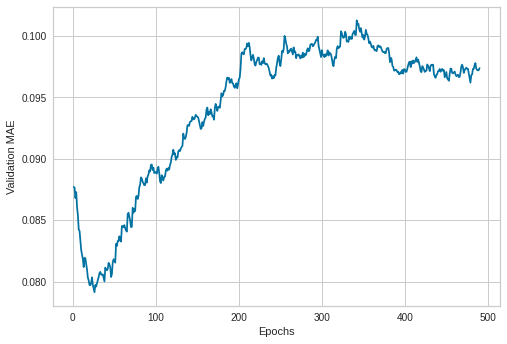

In [85]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

51.644061898529586


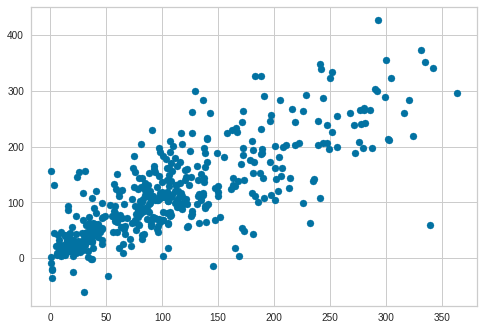

In [87]:
pred = model.predict(norm_val_X)
denorm_pred = denormalize_y(pred)
plt.scatter(val_y, denorm_pred)
print(mean_squared_error(val_y, denorm_pred)**0.5)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                640       
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
62/62 [==============================] - 0s 2ms/step - loss: 0.0232 - mae: 0.1144
Epoch 2/30
62/62 [==============================] - 0s 2ms/step - loss: 0.0168 - mae: 0.0974
Epoch 3/30
62/62 [==============================] - 0s 2ms/step - loss: 0.0166 - mae: 0.0971
Epoch 4/30
62/62 [==================

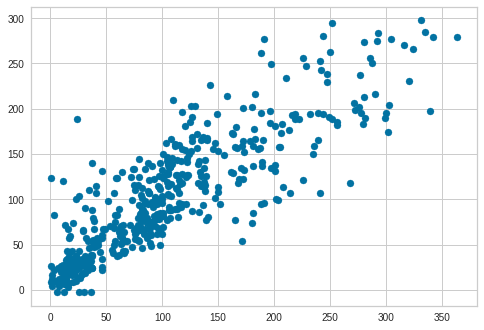

In [89]:
model = build_model()  # 새롭게 컴파일된 모델을 얻습니다.
model.fit(train_data, train_targets,  # 전체 데이터로 훈련시킵니다.
          epochs=30, batch_size=16, verbose=1)
pred = model.predict(norm_val_X)
denorm_pred = denormalize_y(pred)
plt.scatter(val_y, denorm_pred)
print(mean_squared_error(val_y, denorm_pred)**0.5)

기존

In [ ]:

history = model.fit(norm_train_X, norm_train_y, epochs=100, verbose=1, batch_size=16, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

loss, mae = model.evaluate(norm_val_X, norm_val_y)
print("loss=", loss)
print("mae=", mae)

##학습된 모델로 예측 데이터 생성

In [ ]:
from sklearn.metrics import mean_squared_error

pred = model.predict(norm_val_X)

In [ ]:
denorm_pred = denormalize_y(pred)
print(denorm_pred[:5])
#denorm_norm_val_y = denormalize_y(norm_val_y)
#print(denorm_norm_val_y[:5])


[[158.56116 ]
 [ 42.70882 ]
 [ 54.017555]
 [233.34578 ]
 [ 69.60311 ]]


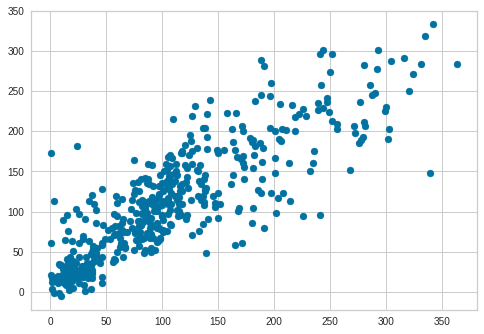

41.35406796740136


In [ ]:
plt.scatter(val_y, denorm_pred)
plt.show()
#print(pred)
print(mean_squared_error(val_y, denorm_pred)**0.5)